In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
cols = open("census-bureau.columns").read().splitlines()
cols

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'wage per hour',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 "fill inc questionnaire for veteran's admin"

In [67]:
df = pd.read_csv('census-bureau.data', sep=',', names=cols)
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [68]:
df['label'].value_counts()/len(df) # check class balance: <50000 is majority class

- 50000.    0.937942
50000+.     0.062058
Name: label, dtype: float64

In [69]:
df = df.assign(encode_label = (df['label']!='- 50000.').astype(int)) # encode target label that <50000 as 0, >50000 as 1

count    199523.000000
mean       1740.380269
std         993.768156
min          37.870000
25%        1061.615000
50%        1618.310000
75%        2188.610000
max       18656.300000
Name: weight, dtype: float64

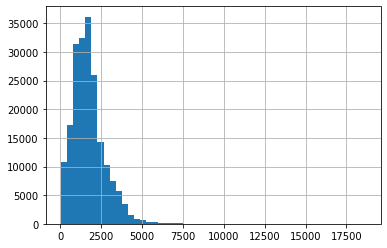

In [70]:
df['weight'].hist(bins=50)
df['weight'].describe() # weight is right skewed, with some outliers.


In [71]:
df.select_dtypes(include='number').columns

Index(['age', 'detailed industry recode', 'detailed occupation recode',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'weight', 'num persons worked for employer',
       'own business or self employed', 'veterans benefits',
       'weeks worked in year', 'year', 'encode_label'],
      dtype='object')

In [72]:
df.isna().sum() # hispanic origin has 874 na

age                                             0
class of worker                                 0
detailed industry recode                        0
detailed occupation recode                      0
education                                       0
wage per hour                                   0
enroll in edu inst last wk                      0
marital stat                                    0
major industry code                             0
major occupation code                           0
race                                            0
hispanic origin                               874
sex                                             0
member of a labor union                         0
reason for unemployment                         0
full or part time employment stat               0
capital gains                                   0
capital losses                                  0
dividends from stocks                           0
tax filer stat                                  0


In [73]:
df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')

In [74]:
df['citizenship'].value_counts() # 0 is majority class, only 7% of data is self-employed.

Native- Born in the United States              176992
Foreign born- Not a citizen of U S              13401
Foreign born- U S citizen by naturalization      5855
Native- Born abroad of American Parent(s)        1756
Native- Born in Puerto Rico or U S Outlying      1519
Name: citizenship, dtype: int64

In [11]:
categorical_cols=['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', # have region of previous residence
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother','country of birth self',
       'citizenship',
       'fill inc questionnaire for veteran\'s admin',
       'detailed industry recode', 'detailed occupation recode',
       'own business or self employed', 'veterans benefits', 'year']

In [12]:
df[categorical_cols].nunique().sort_values(ascending=False)

detailed industry recode                      52
state of previous residence                   51
detailed occupation recode                    47
country of birth self                         43
country of birth mother                       43
country of birth father                       43
detailed household and family stat            38
major industry code                           24
education                                     17
major occupation code                         15
migration code-move within reg                10
migration code-change in msa                  10
class of worker                                9
hispanic origin                                9
migration code-change in reg                   9
detailed household summary in household        8
full or part time employment stat              8
marital stat                                   7
region of previous residence                   6
reason for unemployment                        6
tax filer stat      

In [17]:
numerical_cols=['age',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'num persons worked for employer',
       'weeks worked in year']
# 'weight' is removed from feature, used as sampling weight during training
categorical_cols=['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 
       # 'region of previous residence',
      #  'state of previous residence', # have region of previous residence
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
      #  'country of birth father', 'country of birth mother','country of birth self',
       'citizenship',
       'fill inc questionnaire for veteran\'s admin',
       # 'detailed industry recode', 'detailed occupation recode',
       'own business or self employed', 'veterans benefits', 
       # 'year'
       ]


In [18]:
df[categorical_cols] = df[categorical_cols].astype('category')

In [75]:
df=df.dropna()

In [37]:
X = df[numerical_cols+categorical_cols]
X.shape

(199523, 32)

In [38]:
# # split data
# X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2,
#                                                                   stratify=y)  # preserves class distribution
# X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2)

In [39]:
# print(X_train.shape, X_val.shape, X_test.shape)

# Exploratory Data Analysis

<Axes: >

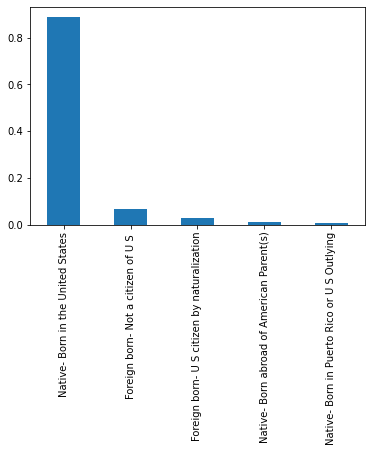

In [40]:
df['citizenship'].value_counts(normalize=True).plot(kind='bar')

<Axes: >

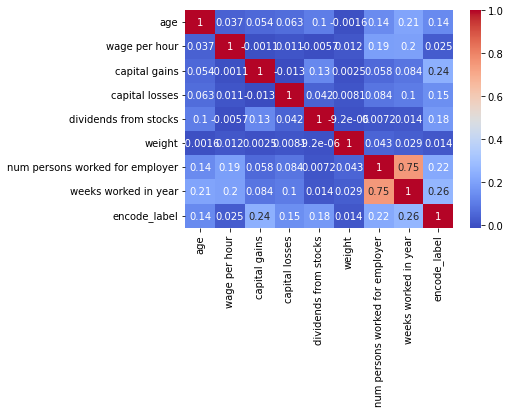

In [41]:
import seaborn as sns
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm')

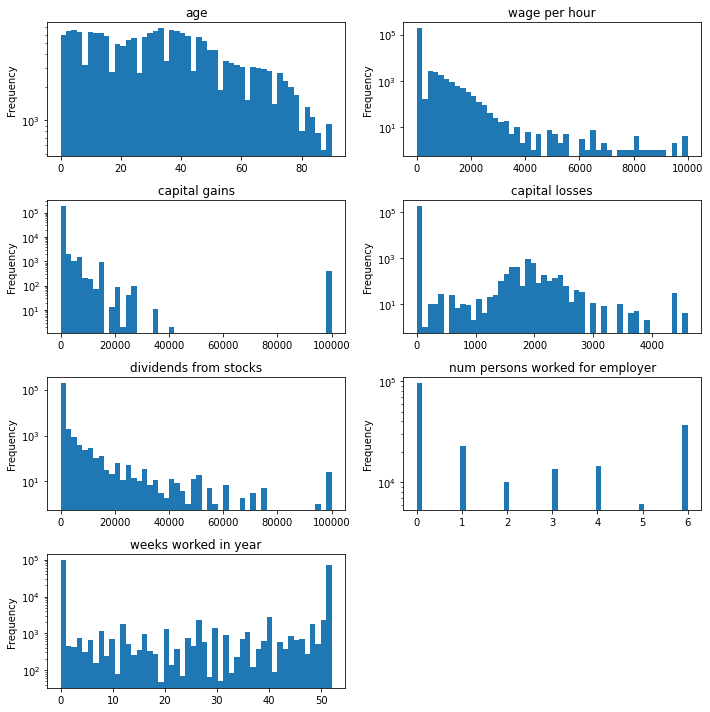

In [ ]:
figure, axes = plt.subplots(4,2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, numerical_cols):
    df[col].plot.hist(bins=50, ax=ax, logy=True) # use log scale for better visualization of skewed distributions
    ax.set_title(col)
# turn off any unused subplots
for ax in axes[len(numerical_cols):]:
    ax.axis('off')#

plt.tight_layout()
plt.show()

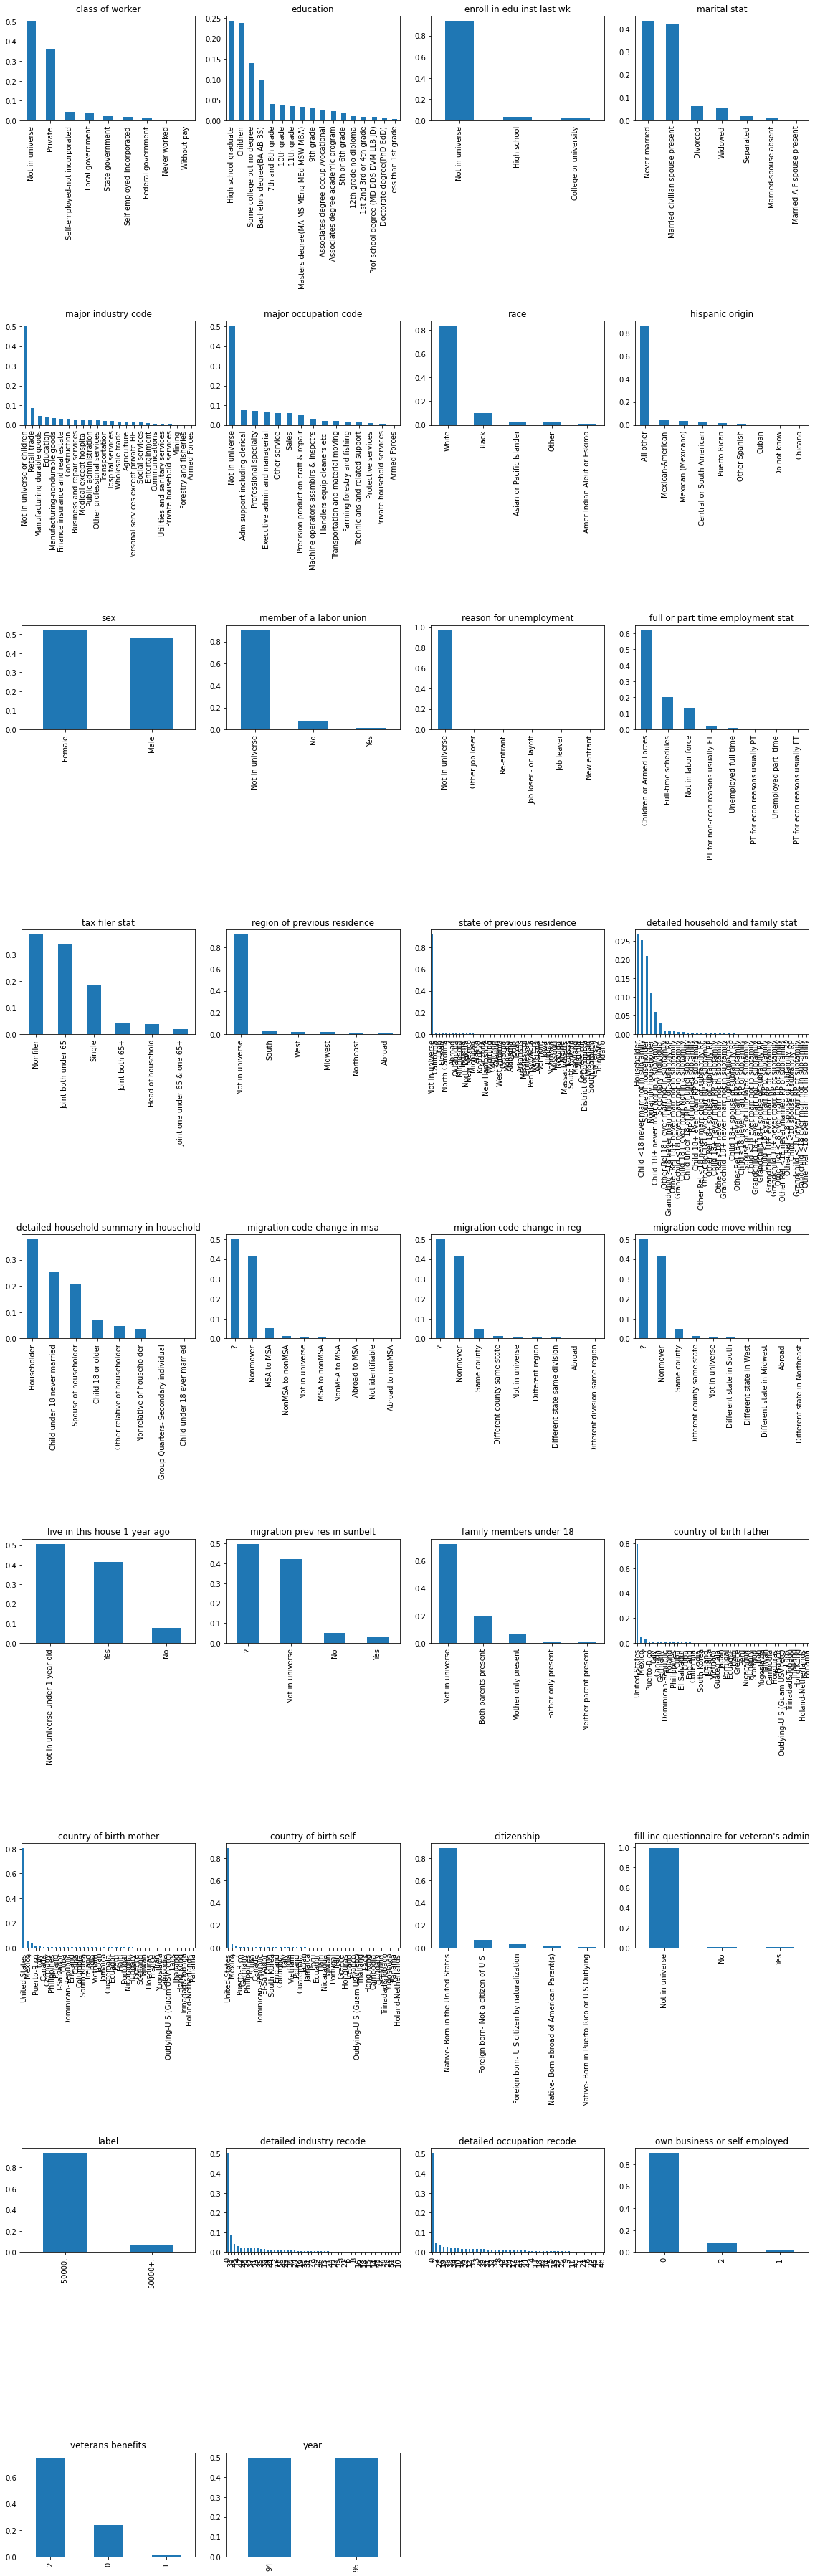

In [ ]:
figure, axes = plt.subplots(9,4, figsize=(16,50))
axes = axes.flatten()
for ax, col in zip(axes, categorical_cols):
    df[col].value_counts(normalize=True).plot.bar(ax=ax)
    ax.set_title(col)
# turn off any unused subplots
for ax in axes[len(categorical_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Feature Engineering

In [42]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown="ignore", sparse=True), categorical_cols)
])

In [43]:
X_processed = preprocess.fit_transform(X)

In [44]:
X_processed.shape

(199523, 222)

In [45]:
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X_processed) # reduce dimensionality for better clustering performance
X_reduced.shape     

(199523, 100)

# Customer Segmentation

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=20)
clusters = kmeans.fit_predict(X_reduced)

In [52]:
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(X), size=10000, replace=False)

for d in [10,30,40,50,60,80,200]:
    svd = TruncatedSVD(n_components=d, random_state=10)
    X_red = svd.fit_transform(X_processed)

    km = KMeans(n_clusters=5, n_init=10)
    labels = km.fit_predict(X_red)

    score = silhouette_score(X_red[sample_idx], labels[sample_idx]) # calculate silhouette score on sample data points for faster computation
    print(d, score)

10 0.36847894401612746
30 0.2569400420952165
40 0.2273363048732177
50 0.21954779199678615
60 0.21373962212434325
80 0.22474542578093223
200 0.21711121521688


SVD dim=10 produces highest silhouette score, meaning low dimension can explain most behavioral difference, and adding too many latent dimension will introduce noise. Extra dimensions mostly encode micro-categories that is irrelevant to segmentation.

In [53]:
svd=TruncatedSVD(n_components=10)
X_reduced = svd.fit_transform(X_processed)
for k in range(4,7):
    km = KMeans(n_clusters=k, n_init=20)
    labels = km.fit_predict(X_reduced)
    print(k, silhouette_score(X_reduced[sample_idx], labels[sample_idx]))

4 0.3536332063531026
5 0.36847905216129156
6 0.37299071771005854


K=5 provides strong separation, as it increases silhouette score the most, while increaseing to k=6 diminishes the marginal effect and introduce unnecessary complexity.

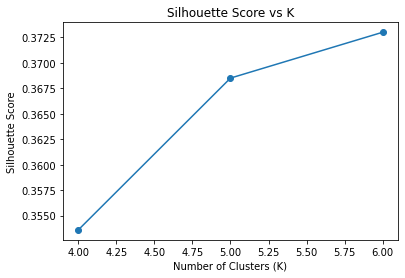

In [55]:
plt.plot([4,5,6], [0.3536, 0.3685, 0.3730], marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.show()

In [56]:
X_reduced = svd.fit_transform(X_processed)
km = KMeans(n_clusters=5, n_init=20)
clusters = km.fit_predict(X_reduced)

In [77]:
df_cluster = df.assign(clusters=clusters)


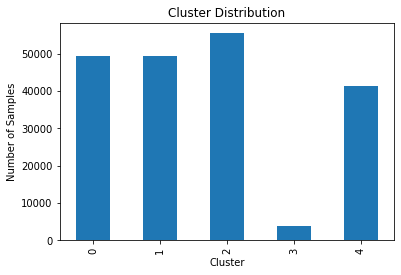

In [82]:
df_cluster.groupby('clusters').count()['age'].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.title('Cluster Distribution')
plt.show()

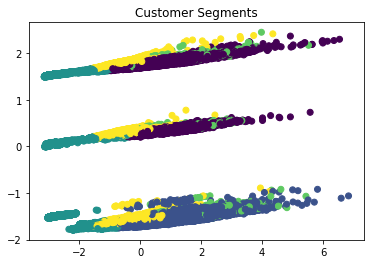

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_reduced)

plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters)
plt.title("Customer Segments")
plt.show()

In [83]:
df_cluster.groupby('clusters')[numerical_cols].mean()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
clusters,,,,,,,
0,38.357379,107.085968,744.817838,0.319772,176.433524,3.666457,44.586120
1,38.387110,109.870073,838.624598,0.384785,203.298417,3.823987,44.925199
2,8.379821,0.510192,0.102356,0.000000,0.897013,0.049464,0.224736
3,43.978175,79.422298,0.000000,1943.011307,727.906127,3.469103,41.672890
4,59.298533,0.184171,204.592291,0.503401,430.053840,0.101843,0.718135


In [ ]:
df_cluster.groupby('clusters')[categorical_cols].agg(lambda x: x.value_counts().index[0])
# cluster 2 is children

,class of worker,education,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,...,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,family members under 18,citizenship,fill inc questionnaire for veteran's admin,own business or self employed,veterans benefits
clusters,,,,,,,,,,,,,,,,,,,,,
0,Private,High school graduate,Not in universe,Married-civilian spouse present,Retail trade,Adm support including clerical,White,All other,Male,Not in universe,...,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Not in universe,Native- Born in the United States,Not in universe,0,2
1,Private,High school graduate,Not in universe,Married-civilian spouse present,Retail trade,Adm support including clerical,White,All other,Male,Not in universe,...,?,?,?,Not in universe under 1 year old,?,Not in universe,Native- Born in the United States,Not in universe,0,2
2,Not in universe,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Male,Not in universe,...,?,?,?,Not in universe under 1 year old,?,Both parents present,Native- Born in the United States,Not in universe,0,0
3,Private,High school graduate,Not in universe,Married-civilian spouse present,Not in universe or children,Professional specialty,White,All other,Male,Not in universe,...,?,?,?,Not in universe under 1 year old,?,Not in universe,Native- Born in the United States,Not in universe,0,2
4,Not in universe,High school graduate,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Female,Not in universe,...,?,?,?,Not in universe under 1 year old,?,Not in universe,Native- Born in the United States,Not in universe,0,2


In [86]:
categorical_cols

['class of worker',
 'education',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'tax filer stat',
 'detailed household and family stat',
 'detailed household summary in household',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'family members under 18',
 'citizenship',
 "fill inc questionnaire for veteran's admin",
 'own business or self employed',
 'veterans benefits']

In [ ]:
df_cluster.groupby(['clusters','sex']).count() # cluster 4 mostly female

age  class of worker  detailed industry recode  \
clusters sex                                                        
0        Female  23786            23786                     23786   
         Male    25593            25593                     25593   
1        Female  23795            23795                     23795   
         Male    25656            25656                     25656   
2        Female  27111            27111                     27111   
         Male    28323            28323                     28323   
3        Female   1049             1049                      1049   
         Male     2754             2754                      2754   
4        Female  28243            28243                     28243   
         Male    13213            13213                     13213   

                 detailed occupation recode  education  wage per hour  \
clusters sex                                                            
0        Female                       23786      23786          23786   
         Male                         25593      25593          25593   
1        Female                       23795      23795          23795   
         Male                         25656      25656          25656   
2        Female                       27111      27111          27111   
         Male                         28323      28323          28323   
3        Female                        1049       1049           1049   
         Male                          2754       2754           2754   
4        Female                       28243      28243          28243   
         Male                         13213      13213          13213   

                 enroll in edu inst last wk  marital stat  \
clusters sex                                                
0        Female                       23786         23786   
         Male                         25593         25593   
1        Female                       23795         23795   
         Male                         25656         25656   
2        Female                       27111         27111   
         Male                         28323         28323   
3        Female                        1049          1049   
         Male                          2754          2754   
4        Female                       28243         28243   
         Male                         13213         13213   

                 major industry code  major occupation code  ...  \
clusters sex                                                 ...   
0        Female                23786                  23786  ...   
         Male                  25593                  25593  ...   
1        Female                23795                  23795  ...   
         Male                  25656                  25656  ...   
2        Female                27111                  27111  ...   
         Male                  28323                  28323  ...   
3        Female                 1049                   1049  ...   
         Male                   2754                   2754  ...   
4        Female                28243                  28243  ...   
         Male                  13213                  13213  ...   

                 country of birth mother  country of birth self  citizenship  \
clusters sex                                                                   
0        Female                    23786                  23786        23786   
         Male                      25593                  25593        25593   
1        Female                    23795                  23795        23795   
         Male                      25656                  25656        25656   
2        Female                    27111                  27111        27111   
         Male                      28323                  28323        28323   
3        Female                     1049                   1049         1049   
         Male                       2754   

In [ ]:
df_cluster.groupby(['clusters','label']).count()  
# cluster 2 almost all <50k income, cluster 4 has higher proportion of >50k income.
# cluster 0 and 1 have more income >50k distribution

age  class of worker  detailed industry recode  \
clusters label                                                        
0        - 50000.  44427            44427                     44427   
         50000+.    4952             4952                      4952   
1        - 50000.  43811            43811                     43811   
         50000+.    5640             5640                      5640   
2        - 50000.  55433            55433                     55433   
         50000+.       1                1                         1   
3        - 50000.   2645             2645                      2645   
         50000+.    1158             1158                      1158   
4        - 50000.  40825            40825                     40825   
         50000+.     631              631                       631   

                   detailed occupation recode  education  wage per hour  \
clusters label                                                            
0        - 50000.                       44427      44427          44427   
         50000+.                         4952       4952           4952   
1        - 50000.                       43811      43811          43811   
         50000+.                         5640       5640           5640   
2        - 50000.                       55433      55433          55433   
         50000+.                            1          1              1   
3        - 50000.                        2645       2645           2645   
         50000+.                         1158       1158           1158   
4        - 50000.                       40825      40825          40825   
         50000+.                          631        631            631   

                   enroll in edu inst last wk  marital stat  \
clusters label                                                
0        - 50000.                       44427         44427   
         50000+.                         4952          4952   
1        - 50000.                       43811         43811   
         50000+.                         5640          5640   
2        - 50000.                       55433         55433   
         50000+.                            1             1   
3        - 50000.                        2645          2645   
         50000+.                         1158          1158   
4        - 50000.                       40825         40825   
         50000+.                          631           631   

                   major industry code  major occupation code  ...  \
clusters label                                                 ...   
0        - 50000.                44427                  44427  ...   
         50000+.                  4952                   4952  ...   
1        - 50000.                43811                  43811  ...   
         50000+.                  5640                   5640  ...   
2        - 50000.                55433                  55433  ...   
         50000+.                     1                      1  ...   
3        - 50000.                 2645                   2645  ...   
         50000+.                  1158                   1158  ...   
4        - 50000.                40825                  40825  ...   
         50000+.                   631                    631  ...   

                   country of birth father  country of birth mother  \
clusters label                                                        
0        - 50000.                    44427                    44427   
         50000+.                      4952                     4952   
1        - 50000.                    43811                    43811   
         50000+.                      5640                     5640   
2        - 50000.                    55433                    55433   
         50000+.                         1                        1   
3        - 50000.                     2645                     2645   
         50000+.              

Text(0.5, 1.0, 'Tax Filer Stats Based on Cluster')

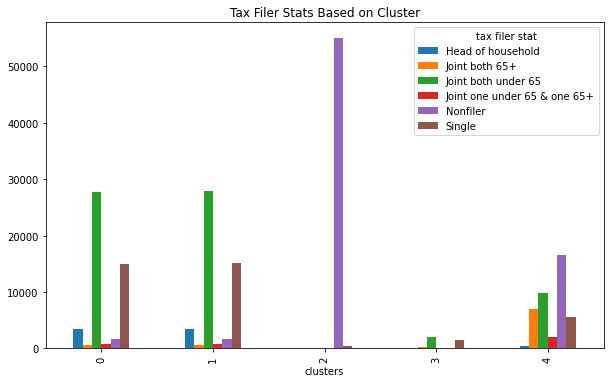

In [105]:
temp_cate_list = ['tax filer stat', 'gender', 'class of worker', 'education', 'enroll in edu inst last wk', 'self employed or not']
df_cluster.groupby(['clusters','tax filer stat']).count()[['age']]
# cluster 2 has mostly single tax filer
# cluster 4 has the most nonfiler, and more likely have joint filer both 65+
# cluster 0 and 1 have more joint tax filers both under 65, and secondly single filer
df_cluster.groupby(['clusters', 'tax filer stat'])['age'].count().unstack(fill_value=0)\
    .plot(kind='bar', figsize=(10, 6))
plt.title('Tax Filer Stats Based on Cluster')

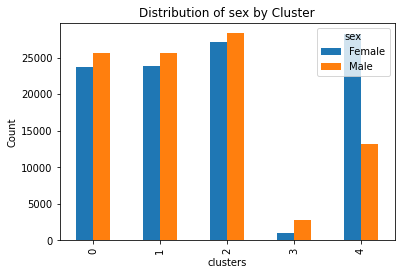

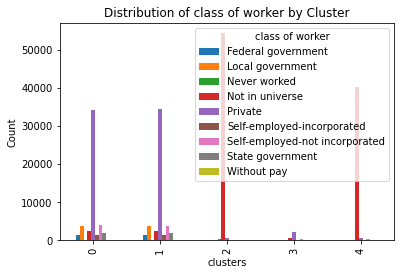

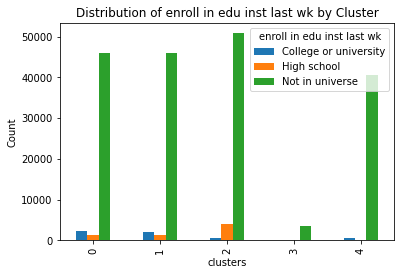

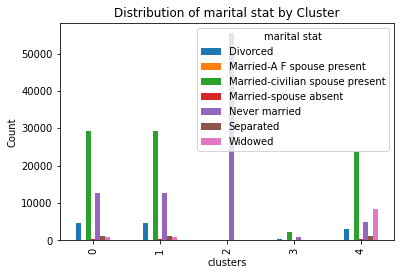

In [113]:
temp_cate_list = ['sex', 'class of worker', 'enroll in edu inst last wk',\
'marital stat']
for i in temp_cate_list:
    df_cluster.groupby(['clusters',i]).size().unstack(fill_value=0).plot(kind='bar', stacked=False)
    plt.title(f'Distribution of {i} by Cluster')
    plt.ylabel('Count')

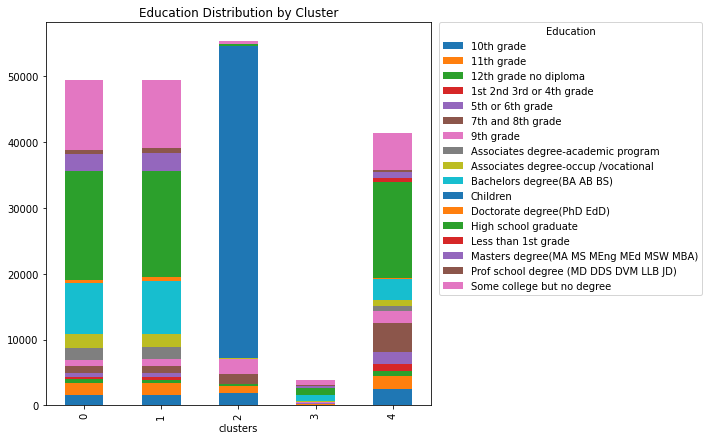

In [ ]:
table = df_cluster.groupby(['clusters', 'education']).size().unstack(fill_value=0)

ax = table.plot(kind='bar', stacked=True, figsize=(10,6))

# Move legend outside
ax.legend(
    title='Education',
    bbox_to_anchor=(1.02, 1),   # push legend to the right
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()  # adjusts layout so nothing gets cut off
plt.title('Education Distribution by Cluster')
plt.show()
# cluster 2 mostly children or teenagers